In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from back_tester import * 
from deep_q_learning import *

In [19]:
#Data
prices = pd.read_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index_col=0, parse_dates=True)
prices = prices[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]

# Load training data
---

In [20]:

#prices_train = prices.loc['2024-01-01 00:00:00':'2024-04-30 23:55:00'] #January training data

prices_train = prices.loc['2024-01-01 00:00:00':'2024-01-31 23:55:00'] #January training data

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_train, sym2_train = prices_train.columns
S1_train = prices_train[sym1_train]
S2_train = prices_train[sym2_train]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_train, beta_series_train, alpha_series_train = compute_spread_series(S1_train, S2_train, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_train, rolling_mean_train, rolling_std_train = compute_rolling_zscore(spread_series_train, window_size)

#Drop NaN values from zscore_series
zscore_series_train = zscore_series_train.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_train = prices_train.loc[zscore_series_train.index]
beta_series_train = beta_series_train.loc[zscore_series_train.index]


Computing spread series and beta series...


In [21]:
zscore_series_train

timestamp
2024-01-03 00:50:00   -0.050043
2024-01-03 00:55:00   -0.001561
2024-01-03 01:00:00   -0.028168
2024-01-03 01:05:00    0.017658
2024-01-03 01:10:00   -0.169765
                         ...   
2024-01-31 23:25:00    0.816195
2024-01-31 23:35:00    0.849163
2024-01-31 23:40:00    0.605611
2024-01-31 23:50:00    0.577522
2024-01-31 23:55:00    1.040269
Length: 7999, dtype: float64

In [47]:
zscore_series_window = zscore_series_train.iloc[0:1000]

start_window = pd.to_datetime('2024-01-03 00:50:00')

pre_window_one_end = pd.to_datetime('2024-01-03 04:17:00')
pre_window_two_end = pd.to_datetime('2024-01-03 10:25:00')

window_one_end = pd.to_datetime('2024-01-03 19:19:00')
window_two_end = pd.to_datetime('2024-01-03 23:10:00')
window_three_end = pd.to_datetime('2024-01-04 3:10:00')
window_four_end = pd.to_datetime('2024-01-04 20:20:00')
window_five_end = pd.to_datetime('2024-01-05 01:25:00')
window_six_end = pd.to_datetime('2024-01-05 7:02:00')

#End of series
window_seven_end = pd.to_datetime('2024-01-05 12:02:00')

zscore_series_window = zscore_series_train.loc[start_window:window_seven_end]
beta_series_window = beta_series_train.loc[start_window:window_seven_end]


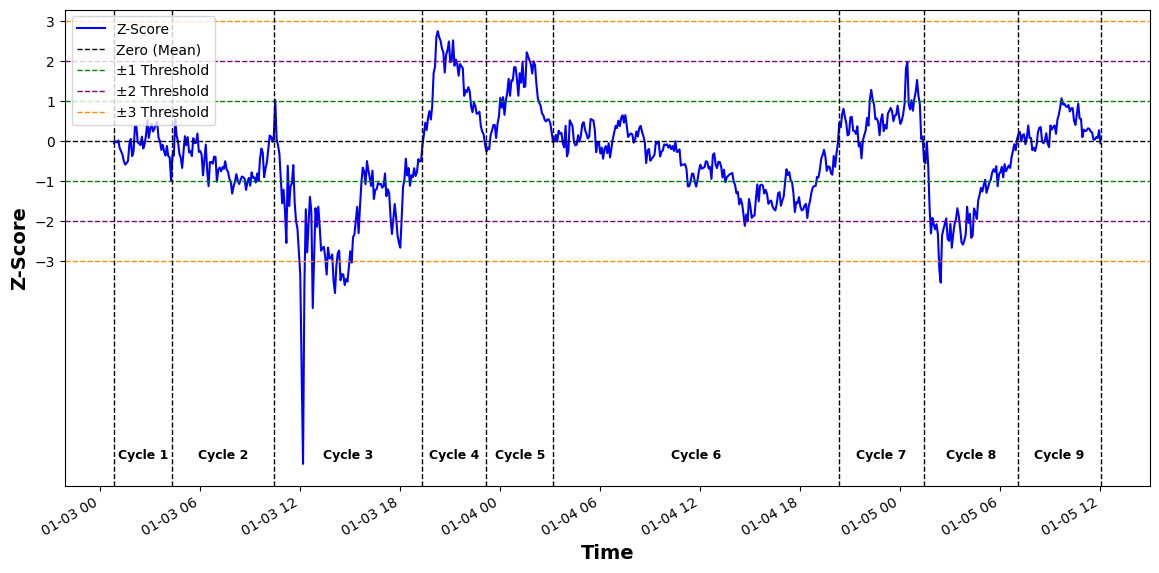

In [49]:



# collect all cycle boundary times in order
cycle_boundaries = [
    start_window,
    pre_window_one_end,
    pre_window_two_end,
    window_one_end,
    window_two_end,
    window_three_end,
    window_four_end,
    window_five_end,
    window_six_end,
    window_seven_end
]

plt.figure(figsize=(14, 7))

# Plot Z-Score series
zscore_series_window.plot(label='Z-Score', color='blue')

# Add horizontal threshold lines
plt.axhline(0, color='black', linestyle='--', linewidth=1, zorder=2, label='Zero (Mean)')
plt.axhline(1, color='green', linestyle='--', linewidth=1, zorder=2, label='±1 Threshold')
plt.axhline(-1, color='green', linestyle='--', linewidth=1, zorder=2)
plt.axhline(2, color='purple', linestyle='--', linewidth=1, zorder=2, label='±2 Threshold')
plt.axhline(-2, color='purple', linestyle='--', linewidth=1, zorder=2)
plt.axhline(3, color='darkorange', linestyle='--', linewidth=1, zorder=2, label='±3 Threshold')
plt.axhline(-3, color='darkorange', linestyle='--', linewidth=1, zorder=2)

# # Add vertical cycle boundary lines (unlabeled in legend)
for t in cycle_boundaries:
    plt.axvline(t, color='black', linestyle='--', linewidth=1)

# Annotate each cycle
ymin, ymax = plt.ylim()
y_offset_frac = 0.05  # fraction of plot height above bottom for labels
for i in range(len(cycle_boundaries) - 1):
    start = cycle_boundaries[i]
    end   = cycle_boundaries[i + 1]
    mid   = start + (end - start) / 2
    plt.text(
        mid, 
        ymin + y_offset_frac * (ymax - ymin),
        f"Cycle {i+1}",
        ha='center', 
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

# Titles and labels
#plt.title('Z-Score of Spread Series')
plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel('Z-Score', fontsize=14, fontweight='bold')

plt.xticks(fontsize =10)
plt.yticks(fontsize =10)

# Force y-ticks to include key levels
plt.yticks([-3, -2, -1, 0, 1, 2, 3])

# Show legend
plt.legend(loc='upper left')

plt.savefig('zscore_thresholds_plot_cycles.png', dpi=300, bbox_inches='tight')
plt.show()


# Benchmark static threshold
---

In [9]:
initial_capital = 10_000
tx_cost = 0.000

entry_threshold = 0.95
exit_threshold = 0
stop_loss_threshold = 1.97

positions, trade_entries, trade_exits = backtest_pair_rolling(S1_train,S2_train,zscore_series_window, entry_threshold, exit_threshold, stop_loss_threshold)
trade_profits, net_trade_profits_S1, net_trade_profits_S2,cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_window, tx_cost)

In [10]:
len(entry_times)

10

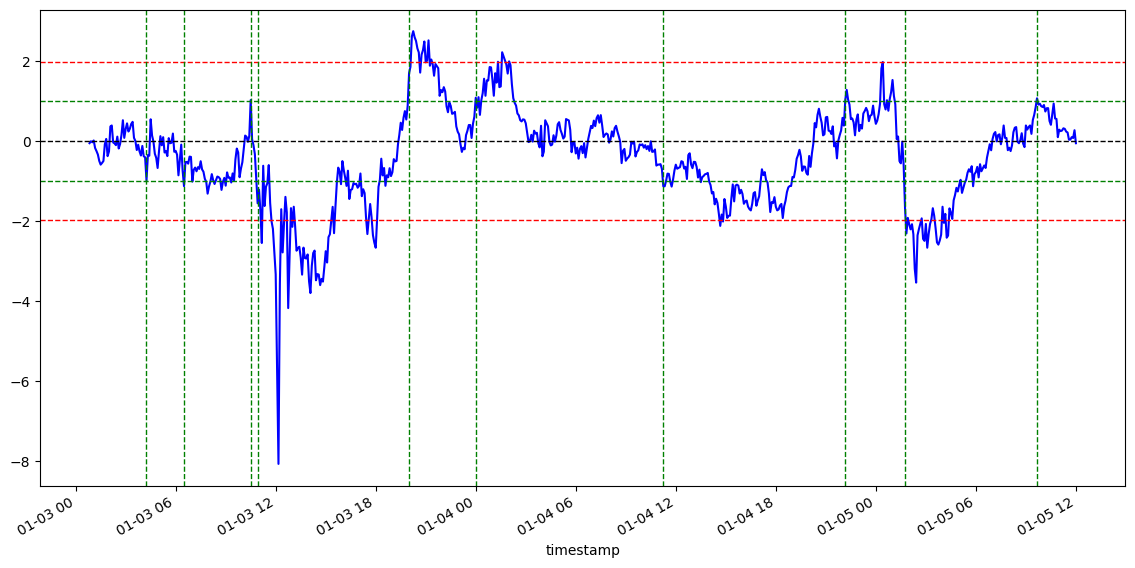

In [11]:
plt.figure(figsize=(14, 7))
zscore_series_window.plot(label='Z-Score', color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(1, color='green', linestyle='--', linewidth=1)
plt.axhline(-1, color='green', linestyle='--', linewidth=1)
plt.axhline(stop_loss_threshold, color='red', linestyle='--', linewidth=1)
plt.axhline(-stop_loss_threshold, color='red', linestyle='--', linewidth=1)

for entry_time in entry_times:
    plt.axvline(entry_time, color='green', linestyle='--', linewidth=1)

# for exit_time in exit_times:
#     plt.axvline(exit_time, color='red', linestyle='--', linewidth=1)

Total return:  -0.3039701150368198 %


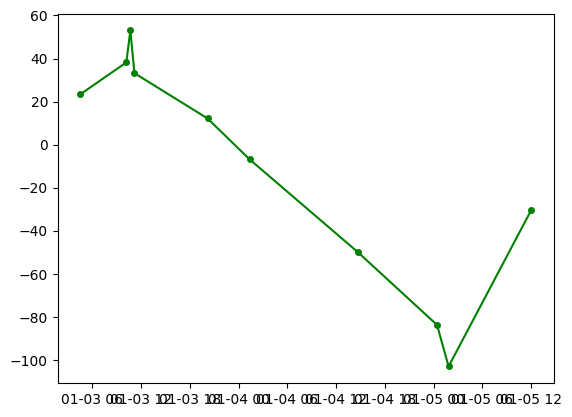

In [12]:
print("Total return: ", cumulative_profit_series.iloc[-1]/initial_capital * 100, "%")
plt.plot(cumulative_profit_series, label='Cumulative Profit', color='green', marker='o', markersize=4)


In [13]:
print(trade_profits)

[np.float64(23.380720118316667), np.float64(14.8048275243466), np.float64(14.827915528353401), np.float64(-19.81657392668427), np.float64(-21.018489377665162), np.float64(-18.956166845902104), np.float64(-43.095421008122386), np.float64(-33.79612900511229), np.float64(-19.264530374133074), np.float64(72.53683586292064)]


# Dynamic threshold model

In [14]:
initial_capital = 10_000
tx_cost = 0.000



dynamic_profit_list = []

#Window 1: Keep default thresholds
#---------------------------------
entry_threshold = 0.95
exit_threshold = 0
stop_loss_threshold = 2

z_score_window_one = zscore_series_window.loc[start_window:window_one_end] #
beta_series_window_one = beta_series_window.loc[start_window:window_one_end] #

positions, trade_entries, trade_exits = backtest_pair_rolling(S1_train,S2_train,z_score_window_one, entry_threshold, exit_threshold, stop_loss_threshold)
trade_profits, net_trade_profits_S1, net_trade_profits_S2,cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_window_one, tx_cost)

dynamic_profit_list.append(trade_profits)

#Window 2: Increase thresholds
#---------------------------------
entry_threshold = 2
exit_threshold = 0
stop_loss_threshold = 3

z_score_window_two = zscore_series_window.loc[window_one_end:window_two_end]
beta_series_window_two = beta_series_window.loc[window_one_end:window_two_end] #

positions, trade_entries, trade_exits = backtest_pair_rolling(S1_train,S2_train,z_score_window_two, entry_threshold, exit_threshold, stop_loss_threshold)
trade_profits, net_trade_profits_S1, net_trade_profits_S2,cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_window_two, tx_cost)

dynamic_profit_list.append(trade_profits)

#Window 3: Increase thresholds
#---------------------------------
entry_threshold = 2
exit_threshold = 0
stop_loss_threshold = 3

z_score_window_three = zscore_series_window.loc[window_two_end:window_three_end]
beta_series_window_three = beta_series_window.loc[window_two_end:window_three_end] #

positions, trade_entries, trade_exits = backtest_pair_rolling(S1_train,S2_train,z_score_window_three, entry_threshold, exit_threshold, stop_loss_threshold)
trade_profits, net_trade_profits_S1, net_trade_profits_S2,cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_window_three, tx_cost)
dynamic_profit_list.append(trade_profits)

#Window 4: Increase thresholds
entry_threshold = 2
exit_threshold = 0
stop_loss_threshold = 3

z_score_window_four = zscore_series_window.loc[window_three_end:window_four_end]
beta_series_window_four = beta_series_window.loc[window_three_end:window_four_end] 

positions, trade_entries, trade_exits = backtest_pair_rolling(S1_train,S2_train,z_score_window_four, entry_threshold, exit_threshold, stop_loss_threshold)
trade_profits, net_trade_profits_S1, net_trade_profits_S2,cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_window_four, tx_cost)

dynamic_profit_list.append(trade_profits)

#Window 5: Increase thresholds 
entry_threshold = 1.97 #Had to adjust this to 1.97 instead of 2 to get a trade
exit_threshold = 0
stop_loss_threshold = 3

z_score_window_five = zscore_series_window.loc[window_four_end:window_five_end]
beta_series_window_five = beta_series_window.loc[window_four_end:window_five_end]

positions, trade_entries, trade_exits = backtest_pair_rolling(S1_train,S2_train,z_score_window_five, entry_threshold, exit_threshold, stop_loss_threshold)
trade_profits, net_trade_profits_S1, net_trade_profits_S2,cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_window_five, tx_cost)

dynamic_profit_list.append(trade_profits)

#Window 6: Decrease thresholds back to normal
entry_threshold = 0.95
exit_threshold = 0
stop_loss_threshold = 2

z_score_window_six = zscore_series_window.loc[window_five_end:window_six_end]
beta_series_window_six = beta_series_window.loc[window_five_end:window_six_end] #
positions, trade_entries, trade_exits = backtest_pair_rolling(S1_train,S2_train,z_score_window_six, entry_threshold, exit_threshold, stop_loss_threshold)
trade_profits, net_trade_profits_S1, net_trade_profits_S2,cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_window_six, tx_cost)

dynamic_profit_list.append(trade_profits)



In [15]:
dynamic_profit_list

[[np.float64(23.380720118316667),
  np.float64(14.8048275243466),
  np.float64(14.827915528353401),
  np.float64(-19.81657392668427)],
 [np.float64(41.337798641413954)],
 [np.float64(48.740692673901336)],
 [np.float64(-9.309061321715888)],
 [np.float64(87.11781813498655)],
 [np.float64(-19.264530374133074), np.float64(72.53683586292064)]]

Total return with dynamic thresholds:  2.543564428617059 %


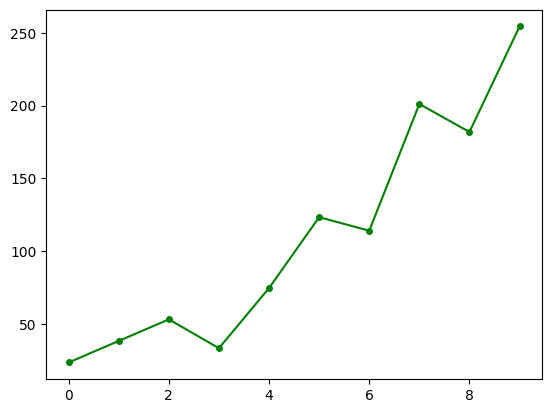

In [16]:
#Flatten dynamic_profit_list
flat_dynamic_profit_list = [item for sublist in dynamic_profit_list for item in sublist]

#Calculate cumulative profit
cumulative_profit = np.cumsum(flat_dynamic_profit_list)

print("Total return with dynamic thresholds: ", cumulative_profit[-1]/initial_capital * 100, "%")
plt.plot(cumulative_profit, label='Cumulative Profit', color='green', marker='o', markersize=4)
